# Домашняя работа №1. 


In [5]:
import sys
sys.path.insert(0, "../src")

import numpy as np
import pandas as pd
import pickle as pkl
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt


In [6]:
with open("../data/prepared.pkl", "rb") as fp:
    prepared = pkl.load(fp)
vocabulary = prepared["vocabulary"]
texts = prepared["texts"]
contexts = prepared["contexts"]
test_texts = prepared["test_texts"]
y_train = prepared["y_train"]
y_test = prepared["y_test"]
text_train = prepared["texts_train"]
text_test = prepared["texts_test"]


## 1. CBOW-модель для тестирования 1-го и 2-гозадания


In [2]:
import torch as th
from types import NoneType
from razdel import tokenize
from typing import Union, Mapping, Any
from pytorch_lightning import LightningModule


class CBOWModel(LightningModule):
    def __init__(self, vocab_size=71186, embedding_dim=128):
        super().__init__()
        self.embeddings = th.nn.Embedding(vocab_size, embedding_dim)
        self.out_layer = th.nn.Linear(embedding_dim, vocab_size)
        self.loss = th.nn.CrossEntropyLoss()
        self.train_outputs = []
        self.val_outputs = []
        self.test_outputs = []
    
    def forward(self, centrals, contexts):
        projections = self.embeddings.forward(contexts).sum(axis=1)
        logits = self.out_layer.forward(projections)
        loss = self.loss(logits, centrals.squeeze())
        return loss
    
    def training_step(self, batch, batch_nb):
        result = self(*batch)
        self.log("loss", result)
        return {'loss': result}
    
    def validation_step(self, batch, batch_nb):
        result = self(*batch)
        self.log("val_loss", result)  
        return {'val_loss': result}

    def test_step(self, batch, batch_nb):
        result = self(*batch)
        self.log("test_loss", result)
        return {'test_loss': self(*batch)}

    def on_train_batch_end(
        self,
        outputs: Union[th.Tensor, Mapping[str, Any], NoneType],
        batch: Any,
        batch_idx: int,
        dataloader_idx: int = 0,
    ) -> None:
        self.train_outputs.append(outputs)
    
    def on_train_epoch_end(self):
        outputs = self.train_outputs
        avg_loss = th.stack([x['loss'] for x in outputs]).mean()
        tensorboard_logs = {'loss': avg_loss}
        self.log("train_loss_epoch", avg_loss, on_step=False, on_epoch=True)
        return {'train_loss_epoch': avg_loss, 'progress_bar': tensorboard_logs}
    
    def on_validation_batch_end(
        self,
        outputs: Union[th.Tensor, Mapping[str, Any], NoneType],
        batch: Any,
        batch_idx: int,
        dataloader_idx: int = 0,
    ) -> None:
        self.val_outputs.append(outputs)
    
    def on_validation_epoch_end(self):
        outputs = self.val_outputs
        avg_loss = th.stack([x['val_loss'] for x in outputs]).mean()
        tensorboard_logs = {'val_loss': avg_loss}
        self.log("val_loss_epoch", avg_loss, on_step=False, on_epoch=True)
        return {'val_loss_epoch': avg_loss, 'progress_bar': tensorboard_logs}

    def on_test_batch_end(
        self,
        outputs: Union[th.Tensor, Mapping[str, Any], NoneType],
        batch: Any,
        batch_idx: int,
        dataloader_idx: int = 0,
    ) -> None:
        self.test_outputs.append(outputs)
    
    def on_test_epoch_end(self):
        outputs = self.test_outputs 
        avg_loss = th.stack([x['test_loss'] for x in outputs]).mean()
        tensorboard_logs = {'test_loss': avg_loss}
        self.log("test_loss_epoch", avg_loss, on_step=False, on_epoch=True)
        return {'test_loss_epoch': avg_loss, 'progress_bar': tensorboard_logs}
    
    def configure_optimizers(self):
        optimizer = th.optim.Adam(self.parameters(), lr=1e-4)
        return [optimizer]


def get_emb_by_text(embeddings, vocabulary, phrase):
    embeddings = np.array(
        [
            embeddings[vocabulary.get_index(word.text.lower())] 
            for word in tokenize(phrase)
        ]
    )
    return np.mean(embeddings, axis=0)


def get_emb_by_tokens(embeddings, vocabulary, tokens):
    vectors = []
    for tok in tokens:
        idx = vocabulary.get_index(tok)
        vec = embeddings[idx,:] 
        vectors.append(vec)
    return np.mean(np.array(vectors), axis=0)


/home/fatuus/advanced-nlp/prj04_emb/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [81]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def most_similar(embeddings, vocabulary, word):
    word_emb = embeddings[vocabulary.get_index(word)]
    similarities = cosine_similarity([word_emb], embeddings)[0]
    top10 = np.argsort(similarities)[-10:]
    return [vocabulary.get_word(index) for index in reversed(top10)]

In [84]:
import bokeh.models as bm, bokeh.plotting as pl
from bokeh.io import output_notebook

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale


def draw_vectors(x, y, radius=10, alpha=0.25, color='blue',
                 width=600, height=400, show=True, **kwargs):
    """ draws an interactive plot for data points with auxilirary info on hover """
    output_notebook()

    if isinstance(color, str):
        color = [color] * len(x)
    data_source = bm.ColumnDataSource({ 'x' : x, 'y' : y, 'color': color, **kwargs })

    fig = pl.figure(active_scroll='wheel_zoom', width=width, height=height)
    fig.scatter('x', 'y', size=radius, color='color', alpha=alpha, source=data_source)

    fig.add_tools(bm.HoverTool(tooltips=[(key, "@" + key) for key in kwargs.keys()]))
    if show:
        pl.show(fig)
    return fig


def get_tsne_projection(word_vectors):
    tsne = TSNE(n_components=2)
    return scale(tsne.fit_transform(word_vectors))

def get_pca_projection(word_vectors):
    pca = PCA(n_components=2)
    return scale(pca.fit_transform(word_vectors))


def visualize_embeddings(embeddings, vocabulary, word_count, method="pca"):
    word_vectors = embeddings[1: word_count + 1]
    words = vocabulary.top(word_count)
    get_projections = get_pca_projection if method == "pca" else get_tsne_projection
    projections = get_projections(word_vectors)
    draw_vectors(projections[:, 0], projections[:, 1], color='green', token=words)

## 2. Задание №1: CBOW

Обчучение модели проводилось с помощью скрипта: [src/cbow.py](../src/cbow.py)


### 2.1 Кривые обучения

In [94]:
# path = "../lightning_logs/[cbow_ns][20240414165354]/logs/lightning_logs/version_0/metrics.csv"
path = "../lightning_logs/[cbow][20240414125953]/logs/lightning_logs/version_0/metrics.csv"
d_metrics = pd.read_csv(path)

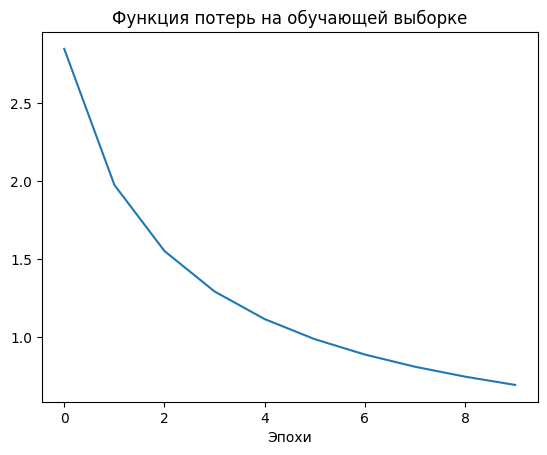

In [96]:
d_train = d_metrics[["epoch", "train_loss_epoch"]].dropna()
plt.plot(d_train.epoch, d_train.train_loss_epoch)
plt.title("Функция потерь на обучающей выборке")
plt.xlabel("Эпохи")
plt.show()


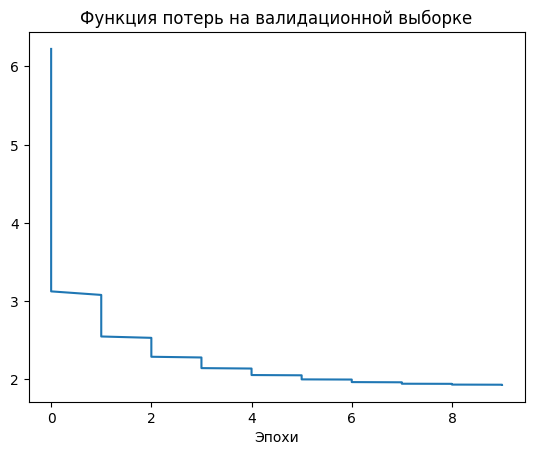

In [97]:
d_val = d_metrics[["epoch", "val_loss_epoch"]].dropna()
plt.plot(d_val.epoch, d_val.val_loss_epoch)
plt.title("Функция потерь на валидационной выборке")
plt.xlabel("Эпохи")
plt.show()


### Тестирование схожести слов

In [82]:
PATH_MODEl = "../lightning_logs/[cbow][20240414125953]/ckpt/last.ckpt"
model = CBOWModel.load_from_checkpoint(PATH_MODEL).eval()
embeddings = model.embeddings.weight.cpu().data.numpy()

most_similar(embeddings, vocabulary, 'путин')

['путин',
 'медработников',
 'ножом',
 'china',
 'обновлении',
 'градоначальник',
 'стрелка',
 'мое',
 '“',
 'display']

### Визуализация векторов

In [85]:
visualize_embeddings(embeddings, vocabulary, 500, method="tsne")

/home/fatuus/advanced-nlp/prj04_emb/venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:261: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/home/fatuus/advanced-nlp/prj04_emb/venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:280: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(


Loading BokehJS ...

###  Тестирование на задаче рубрикации 

In [44]:
X_train = np.zeros((len(text_train), embeddings.shape[1]))
for i, text in enumerate(text_train):
    X_train[i, :] = get_emb_by_tokens(embeddings, vocabulary, text)

X_test = np.zeros((len(text_test), embeddings.shape[1]))
for i, text in enumerate(text_test):
    X_test[i, :] = get_emb_by_text(embeddings, vocabulary, text)

print(X_train.shape)
print(y_train.shape)


(63356, 128)
(63356,)


In [100]:
est = lgb.LGBMClassifier(
    n_estimators=500,
    subsample=0.6,
    max_depth=2,
    min_child_samples=100,
    verbose=0
)
est.fit(X_train, y_train)
p_train = est.predict_proba(X_train)
cbow_train = roc_auc_score(y_true=y_train, y_score=p_train, multi_class="ovo")
p_test = est.predict_proba(X_test)
cbow_test = roc_auc_score(y_true=y_test, y_score=p_test, multi_class="ovo")

pd.DataFrame(dict(cbow_train=[cbow_train], cbow_test=[cbow_test]))


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


,cbow_train,cbow_test
0,0.916947,0.589776


In [49]:
cbow_train, cbow_test

(0.9141214466246638, 0.5879915739410224)

## Задача №2: CBOW  с применением Negative Sampling
Обчучение модели проводилось с помощью скрипта: [src/cbow_ns.py](../src/cbow_ns.py)


### Тестирование схожести слов

In [51]:
PATH_MODEL ="../lightning_logs/[cbow_ns][20240414101659]/ckpt/last.ckpt"
model = CBOWModel.load_from_checkpoint(PATH_MODEL).eval()
embeddings = model.embeddings.weight.cpu().data.numpy()
most_similar(embeddings, vocabulary, 'путин')

['путин',
 'медработников',
 'ножом',
 'china',
 'обновлении',
 'градоначальник',
 'стрелка',
 'мое',
 '“',
 'display']

### Визуализация векторов

In [52]:
visualize_embeddings(embeddings, vocabulary, 500, method="tsne")

/home/fatuus/advanced-nlp/prj04_emb/venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:261: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/home/fatuus/advanced-nlp/prj04_emb/venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:280: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(


Loading BokehJS ...

###  Тестирование на задаче рубрикации 

In [98]:
est = lgb.LGBMClassifier(
    n_estimators=500,
    subsample=0.6,
    max_depth=2,
    min_child_samples=100,
    verbose=0
)
est.fit(X_train, y_train)
p_train = est.predict_proba(X_train)
cbow_ns_train = roc_auc_score(y_true=y_train, y_score=p_train, multi_class="ovo")

p_test = est.predict_proba(X_test)
cbow_ns_test = roc_auc_score(y_true=y_test, y_score=p_test, multi_class="ovo")

pd.DataFrame(dict(cbow_ns_train=[cbow_ns_train], cbow_ns_test=[cbow_ns_test]))


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


,cbow_ns_train,cbow_ns_test
0,0.916947,0.589776


## Задача №3: Рубрикация текстов с XLMRoBerta

Векторизация текста посредством XLM-R проводилась с помощью HuggingFace в отдельном скрипте: [../src/make_xlmr_embs.py](../src/make_xlmr_embs.py)

In [65]:
from transformers import AutoTokenizer, AutoModelForMaskedLM

tokenizer = AutoTokenizer.from_pretrained('xlm-roberta-base')
model = AutoModelForMaskedLM.from_pretrained("xlm-roberta-base").eval().cuda()


Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForMaskedLM: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [67]:
xlmr_train = np.load("../data/xmlr_train.npy")
xlmr_test = np.load("../data/xmlr_embs_test.npy")

In [68]:
est = lgb.LGBMClassifier(
    n_estimators=500,
    subsample=0.6,
    max_depth=2,
    min_child_samples=100,
    verbose=0
)
est.fit(xlmr_train, y_train)


p_train = est.predict_proba(xlmr_train)
xlrm_train_score = roc_auc_score(y_true=y_train, y_score=p_train, multi_class="ovo")

p_test = est.predict_proba(xlmr_test)
xlrm_test_score = roc_auc_score(y_true=y_test, y_score=p_test, multi_class="ovo")

pd.DataFrame(
    dict(xlrm_train_score=[xlrm_train_score], xlrm_test_score=[xlrm_test_score])
)

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


,xlrm_train_score,xlrm_test_score
0,0.996132,0.982139


#### Сравнение метрик:

In [88]:
pd.DataFrame(
    [
        {"model": "CBOW", "auc_train": cbow_train, "auc_test": cbow_test},
        {"model": "CBOW NS", "auc_train": cbow_ns_train, "auc_test": cbow_ns_test},
        {"model": "XLM-R", "auc_train": xlrm_train_score, "auc_test": xlrm_test_score}
    ]
)

,model,auc_train,auc_test
0,CBOW,0.916947,0.589776
1,CBOW NS,0.916947,0.589776
2,XLM-R,0.996132,0.982139


# Выводы
1. XLM-R наилучшим образом справляется с задачей рубрикации. Возможные причины:
   - На обучение XLM-R было затрачено больше ресурсов
   - XLM-R - более эффективная модель
   - Необходимо провести доработки в обчении: тюнинг, более эффективный пайплайн, поиск ошибкок 
2. Не смотря на то, что у CBOW и CBOW-NS функция потерь снижалась со временем. Эмбеддинги плохо показали  себя в задаче рубрикации. Что также указывает на необходимость проведения доработок.

